In [ ]:
import pandas as pd

# Load dataset directly from GitHub
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Quick view
print(df.head())
print(df['Churn'].value_counts())  # Check churn distribution

In [5]:
# Show columns with non-numeric data types
non_numeric_cols = df.select_dtypes(include=['object', 'bool']).columns
print("Columns to encode:\n", non_numeric_cols)

Columns to encode:
 Index(['MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [6]:
# Convert all boolean columns to integers
df[non_numeric_cols] = df[non_numeric_cols].astype(int)

In [7]:
# Replace 'No internet service' and similar with just 'No'
df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)

In [8]:
# Again get object type columns (after previous cleaning)
remaining_obj_cols = df.select_dtypes(include='object').columns

# Apply one-hot encoding
df = pd.get_dummies(df, columns=remaining_obj_cols, drop_first=True)

In [9]:
print(df.dtypes)  # Should now be all int or float
print(df.head())

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service             int64
MultipleLines_Yes                          int64
InternetService_Fiber optic                int64
InternetService_No                         int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
OnlineBackup_No internet service           int64
OnlineBackup_Yes                           int64
DeviceProtection_No internet service       int64
DeviceProtection_Yes                       int64
TechSupport_No inter

In [22]:
df.shape

(7032, 31)

Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_split': 2}
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}

=== Decision Tree Metrics ===
Accuracy: 0.7824644549763033
Precision: 0.6517857142857143
Recall: 0.39037433155080214
F1-score: 0.4882943143812709
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      1549
           1       0.65      0.39      0.49       561

    accuracy                           0.78      2110
   macro avg       0.73      0.66      0.68      2110
weighted avg       0.77      0.78      0.76      2110


=== Random Forest Metrics ===
Accuracy: 0.7919431279620853
Precision: 0.6452380952380953
Recall: 0.483065953654189
F1-score: 0.5524974515800204
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.65      0.48      0.55       561

    

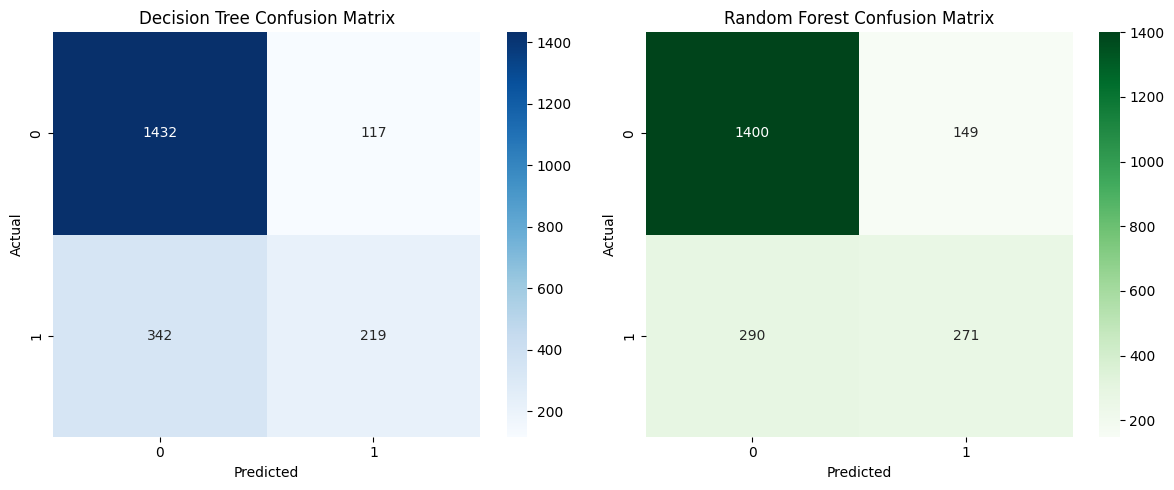

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings("ignore")

# Load Telco Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Encode binary categorical columns
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['Partner'] = df['Partner'].map({'No': 0, 'Yes': 1})
df['Dependents'] = df['Dependents'].map({'No': 0, 'Yes': 1})
df['PhoneService'] = df['PhoneService'].map({'No': 0, 'Yes': 1})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'No': 0, 'Yes': 1})

# One-hot encode multi-class columns
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies', 'Contract',
                                 'PaymentMethod'], drop_first=True)

# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------------
# Decision Tree with GridSearch
# ------------------------------
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       dt_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
dt_preds = dt_best.predict(X_test)

# ------------------------------
# Random Forest with GridSearch
# ------------------------------
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)

# ------------------------------
# Metrics function
# ------------------------------
def print_metrics(model_name, y_true, y_pred):
    print(f"\n=== {model_name} Metrics ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# ------------------------------
# Results
# ------------------------------
print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Random Forest Parameters:", rf_grid.best_params_)

# Decision Tree Results
dt_cm = confusion_matrix(y_test, dt_preds)
print_metrics("Decision Tree", y_test, dt_preds)

# Random Forest Results
rf_cm = confusion_matrix(y_test, rf_preds)
print_metrics("Random Forest", y_test, rf_preds)

# ------------------------------
# Visualize Confusion Matrices
# ------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [14]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,True,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,False,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,False,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,False,...,True,False,True,False,True,True,False,False,False,True
7039,0,0,1,1,72,1,1,103.20,7362.90,False,...,False,False,True,False,True,True,False,True,False,False
7040,0,0,1,1,11,0,1,29.60,346.45,True,...,False,False,False,False,False,False,False,False,True,False
7041,1,1,1,0,4,1,1,74.40,306.60,False,...,False,False,False,False,False,False,False,False,False,True


In [16]:

y


,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1
